<a href="https://colab.research.google.com/github/Zhangmingyang-Su/Data-Analysis-Projects/blob/master/Amazon_Prime_Video_Time_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 0 Load packages, load data


In [0]:
#import neccessary libraries
import numpy as np
import pandas as pd
import sklearn as sl
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('max_colwidth',100)


In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1-VwHP1WTZFrSkS4-6JE4Hk-fI58_Qeih'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) 
file.GetContentFile('amazon prime.csv')

In [4]:
TV=pd.read_table('amazon prime.csv',header=0,sep=',',lineterminator='\n')
print(TV.head())

   video_id  cvt_per_day  weighted_categorical_position  \
0    385504   307127.606                              1   
1    300175   270338.426                              1   
2    361899   256165.867                              1   
3    308314   196622.721                              3   
4    307201   159841.652                              1   

   weighted_horizontal_poition  import_id  release_year  \
0                            3  lionsgate          2013   
1                            3  lionsgate          2013   
2                            3      other          2012   
3                            4  lionsgate          2008   
4                            3  lionsgate          2013   

                                          genres  imdb_votes    budget  \
0                          Action,Thriller,Drama       69614  15000000   
1                          Comedy,Crime,Thriller       46705  15000000   
2                                    Crime,Drama      197596  260000

# Part 1: Data Exploration

## 1.1 Exclude erroneous data

Each video should only appear once in the list, duplicated video will be removed.

In [5]:
if TV.set_index('video_id').index.duplicated().sum()==0:
  print('no duplicated index')
  

no duplicated index


## 1.2 Understand numerical features

### 1.2.1 Overview

In [6]:
TV.info()
print(TV.drop(columns=['video_id','release_year'],axis=1).describe(percentiles=[0.1,0.25,0.5,0.75,0.95]))
(TV==0).sum(axis=0)/TV.shape[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 16 columns):
video_id                         4226 non-null int64
cvt_per_day                      4226 non-null float64
weighted_categorical_position    4226 non-null int64
weighted_horizontal_poition      4226 non-null int64
import_id                        4226 non-null object
release_year                     4226 non-null int64
genres                           4226 non-null object
imdb_votes                       4226 non-null int64
budget                           4226 non-null int64
boxoffice                        4226 non-null int64
imdb_rating                      4226 non-null float64
duration_in_mins                 4226 non-null float64
metacritic_score                 4226 non-null int64
awards                           4226 non-null object
mpaa                             4226 non-null object
star_category                    4226 non-null float64
dtypes: float64(4), int64(8), obj

video_id                        0.000
cvt_per_day                     0.000
weighted_categorical_position   0.000
weighted_horizontal_poition     0.000
import_id                       0.000
release_year                    0.000
genres                          0.000
imdb_votes                      0.081
budget                          0.581
boxoffice                       0.756
imdb_rating                     0.081
duration_in_mins                0.000
metacritic_score                0.713
awards                          0.000
mpaa                            0.000
star_category                   0.437
dtype: float64

### 1.2.2 cvt_per_day feature

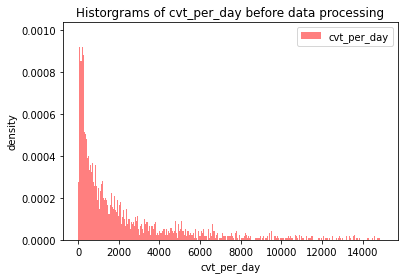

In [11]:
plt.hist(TV['cvt_per_day'],bins=range(0,15000,30),color='r',label='cvt_per_day',density=True,alpha=0.5)
plt.title('Historgrams of cvt_per_day before data processing')
plt.legend(loc='upper right')
plt.xlabel('cvt_per_day')
plt.ylabel('density')
plt.show()

### 1.2.3 Correlation among numerical features

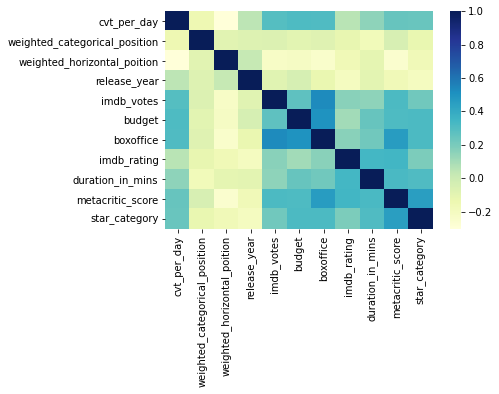

In [13]:
corr = TV[['cvt_per_day','weighted_categorical_position','weighted_horizontal_poition'
               ,'release_year', 'imdb_votes', 'budget', 'boxoffice' ,'imdb_rating', 
               'duration_in_mins', 'metacritic_score', 'star_category']].corr()

sns.heatmap(corr, cmap="YlGnBu")

In [15]:
corr

,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,release_year,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category
cvt_per_day,1.000,-0.148,-0.302,0.046,0.298,0.316,0.312,0.059,0.152,0.249,0.247
weighted_categorical_position,-0.148,1.000,-0.084,-0.069,-0.064,-0.090,-0.074,-0.116,-0.174,-0.044,-0.123
weighted_horizontal_poition,-0.302,-0.084,1.000,0.027,-0.221,-0.211,-0.245,-0.162,-0.102,-0.255,-0.168
release_year,0.046,-0.069,0.027,1.000,-0.083,-0.040,-0.128,-0.199,-0.097,-0.167,-0.198
imdb_votes,0.298,-0.064,-0.221,-0.083,1.000,0.273,0.531,0.163,0.156,0.322,0.225
budget,0.316,-0.090,-0.211,-0.040,0.273,1.000,0.505,0.106,0.251,0.315,0.322
boxoffice,0.312,-0.074,-0.245,-0.128,0.531,0.505,1.000,0.164,0.226,0.465,0.322
imdb_rating,0.059,-0.116,-0.162,-0.199,0.163,0.106,0.164,1.000,0.344,0.347,0.192
duration_in_mins,0.152,-0.174,-0.102,-0.097,0.156,0.251,0.226,0.344,1.000,0.327,0.309
metacritic_score,0.249,-0.044,-0.255,-0.167,0.322,0.315,0.465,0.347,0.327,1.000,0.452


## 1.3 Understand categorical features

### 1.3.1 Distribution of standard categorical features

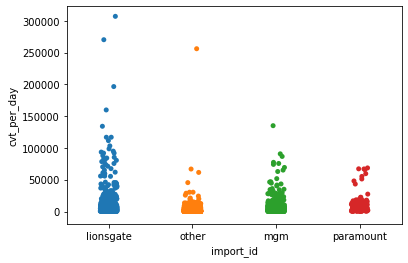

other        2963
lionsgate     677
mgm           445
paramount     141
Name: import_id, dtype: int64


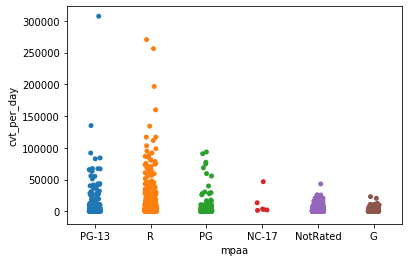

NotRated    2158
R           1158
PG-13        426
PG           353
G            125
NC-17          6
Name: mpaa, dtype: int64


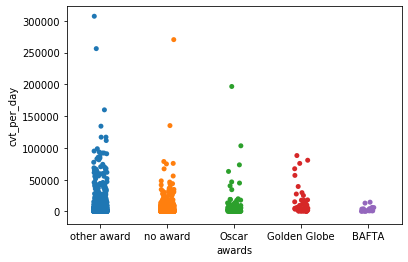

no award        2569
other award     1453
Oscar            141
Golden Globe      44
BAFTA             19
Name: awards, dtype: int64


In [16]:
sns.stripplot(x='import_id', y='cvt_per_day', data=TV,jitter=True)
plt.show()
print(TV['import_id'].value_counts())

sns.stripplot(x='mpaa', y='cvt_per_day', data=TV,jitter=True)
plt.show()
print(TV['mpaa'].value_counts())

sns.stripplot(x='awards', y='cvt_per_day', data=TV, jitter=True)
plt.show()
print(TV['awards'].value_counts())

After very basic Exploratory Data Analysis, we have to do some data cleaning and data preprocessing.
We need three steps to finish  this.
First, we need to encode the categorical feature
Second, we need to impute the missing value for both numeric and categorical feature
Third, we need to scale out feature,which can be better for our models' performance

### 1.3.2 Distribution of splited genres

Some videos belongs to more than 1 genre, the genre of each video is splited, this would help emphasize the effect of each individual genre.

Action                    739
Adult                       3
Adventure                 363
Animation                 129
Anime                      11
Comedy                   1184
Crime                     437
Documentary               671
Drama                    1677
Fantasy                   243
Foreign/International      64
Holiday                     1
Horror                    762
Independent               393
Kids & Family             280
LGBT                        2
Lifestyle                   7
Music                     171
Musicals                   68
Mystery                   375
Reality                     9
Romance                   591
Sci-Fi                    363
Sport                      77
Thriller                  879
War                       102
Western                   102
dtype: int64


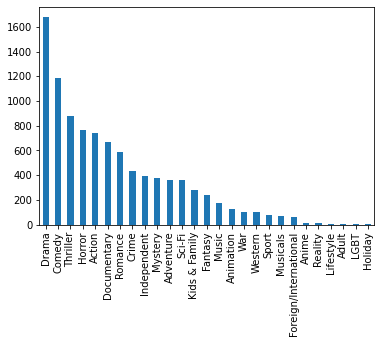

In [16]:
# generes explore, split the genre of each video
gen_split = TV['genres'].str.get_dummies(sep=',').sum()
print(gen_split)

gen_split.sort_values(ascending=False).plot.bar()

### 1.3.3 Distribution of release_year

The release year of video varies through a wide range. Considering the popularity of a video usually decays over time, the release_year should be bucketed based on the release_year range.

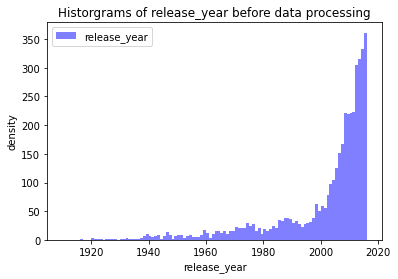

In [19]:
plt.hist(TV['release_year'].values, bins = range(1910, 2017, 1), alpha = 0.5, color='b', label = 'release_year')
plt.legend(loc ='upper left')
plt.title('Historgrams of release_year before data processing')
plt.xlabel('release_year')
plt.ylabel('density')
plt.show()


# Part 2: Feature Preprocessing

## 2.1 Categorical features

There are 5 categorical features: import_id, mpaa, awards, genres, and release_year. There is no missing data in them. They can be converted into dummy/indicators.

The first 3 have relatively small sub-types, they can be easily converted to dummies.

The 'genres' have 27 different sub-types, 6 of them are rarely observed (refer to previous section). It's reasonable to group these 6 into 1. Note: a video may have more than one genre, in the feature preprocessing, all genres are handled individually.

The release_year is bined into 10 buckets based on the year range between 1917 and 2017.

In [0]:
# Convert 3 Categorical variables into dummy variables
d_import_id = pd.get_dummies(TV['import_id']).astype(np.int64)
d_mpaa = pd.get_dummies(TV['mpaa']).astype(np.int64)
d_awards = pd.get_dummies(TV['awards']).astype(np.int64)

In [0]:
# Convert 'genres' into dummy variables
d_genres=TV['genres'].str.get_dummies(sep=',').astype(np.int64)
d_genres['Misc_genres']=d_genres['Anime']|d_genres['Reality']|d_genres['Lifestyle']|d_genres['Adult']|d_genres['LGBT']|d_genres['Holiday']
d_genres.drop(['Anime', 'Reality','Lifestyle', 'Adult','LGBT','Holiday'], inplace=True, axis=1)

In [0]:
# bin release_year and convert into dummies
bin_year = [1916, 1974, 1991, 2001, 2006, 2008, 2010, 2012, 2013, 2014,2017]
year_range = ['1916-1974', '1974-1991', '1991-2001', '2001-2006','2006-2008','2008-2010','2010-2012','2012-2013',
              '2013-2014','2014-2017']
year_bin = pd.cut(TV['release_year'], bin_year, labels=year_range)
d_year = pd.get_dummies(year_bin).astype(np.int64)

In [28]:
# new dataframe, drop the previous categorical features, add new dummy variables, check for null

temp_tv=TV.drop(['import_id', 'mpaa','awards','genres', 'release_year'], axis=1)

newTV = pd.concat([temp_tv, d_import_id, d_mpaa, d_awards, d_genres, d_year], axis=1)
print(newTV.head())

   video_id  cvt_per_day  weighted_categorical_position  \
0    385504   307127.606                              1   
1    300175   270338.426                              1   
2    361899   256165.867                              1   
3    308314   196622.721                              3   
4    307201   159841.652                              1   

   weighted_horizontal_poition  imdb_votes    budget  boxoffice  imdb_rating  \
0                            3       69614  15000000   42930462        6.500   
1                            3       46705  15000000    3301046        6.500   
2                            3      197596  26000000   37397291        7.300   
3                            4      356339  15000000   15700000        7.600   
4                            3       46720  27220000    8551228        6.400   

   duration_in_mins  metacritic_score  star_category  lionsgate  mgm  other  \
0           112.301                51          1.710          1    0      0   
1     

## 2.2 Missing data

Among the 10 numerical features (not include video_id), 4 features have over 25% of missing values (shown as '0', which is not possible in reality): budget, boxoffice, metacritic_score, star_category. 2 features have less than 10% of missing data: imdb_votes, imdb_rating.

There are 3242 samples have at least one missing data.

Right Now we have to deal with the missing data. According to the data info, there is no Null value in our dataset.
That's good, but we have to be catious, cause zero value can be a very good candidate for missing data. 
So we have the check the ratio of zero value in our numeric feature

In [29]:
newTV[['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']] = newTV[['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']].replace(0, np.nan)
print(newTV.info())
print(newTV.isnull().sum()/newTV.shape[0])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 58 columns):
video_id                         4226 non-null int64
cvt_per_day                      4226 non-null float64
weighted_categorical_position    4226 non-null int64
weighted_horizontal_poition      4226 non-null int64
imdb_votes                       3882 non-null float64
budget                           1772 non-null float64
boxoffice                        1032 non-null float64
imdb_rating                      3882 non-null float64
duration_in_mins                 4226 non-null float64
metacritic_score                 1214 non-null float64
star_category                    2380 non-null float64
lionsgate                        4226 non-null int64
mgm                              4226 non-null int64
other                            4226 non-null int64
paramount                        4226 non-null int64
G                                4226 non-null int64
NC-17                        

Filling missing data with mean value

In [30]:
newTV1=newTV.copy()
newTV1['boxoffice']=newTV1['boxoffice'].fillna(newTV1['boxoffice'].mean())
newTV1['metacritic_score']=newTV1['metacritic_score'].fillna(newTV1['metacritic_score'].mean())
newTV1['star_category']=newTV1['star_category'].fillna(newTV1['star_category'].mean())
newTV1['imdb_votes']=newTV1['imdb_votes'].fillna(newTV1['imdb_votes'].mean())
newTV1['imdb_rating']=newTV1['imdb_rating'].fillna(newTV1['imdb_rating'].mean())
newTV1['budget']=newTV1['budget'].fillna(newTV1['budget'].mean())
print(newTV1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 58 columns):
video_id                         4226 non-null int64
cvt_per_day                      4226 non-null float64
weighted_categorical_position    4226 non-null int64
weighted_horizontal_poition      4226 non-null int64
imdb_votes                       4226 non-null float64
budget                           4226 non-null float64
boxoffice                        4226 non-null float64
imdb_rating                      4226 non-null float64
duration_in_mins                 4226 non-null float64
metacritic_score                 4226 non-null float64
star_category                    4226 non-null float64
lionsgate                        4226 non-null int64
mgm                              4226 non-null int64
other                            4226 non-null int64
paramount                        4226 non-null int64
G                                4226 non-null int64
NC-17                        

There are two most common used scaling method: normalization and standardscaler
If there are no specific requirement for the range of output, we choose to use standardscaler

## 2.3 Feature scaling

The impact of different scaling methods on the model performance is small. In the following model training and selections, the standard scaling (sc) data is used.

In [33]:
#Standard scaling
scale_lst = ['weighted_categorical_position', 'weighted_horizontal_poition', 'budget','boxoffice', 
             'imdb_votes','imdb_rating','duration_in_mins', 'metacritic_score','star_category']
newTV_sc = newTV1.copy()

sc_scale = StandardScaler().fit(newTV_sc[scale_lst])
newTV_sc[scale_lst] = sc_scale.transform(newTV_sc[scale_lst])

newTV_sc.head()


,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category,lionsgate,mgm,other,paramount,G,NC-17,NotRated,PG,PG-13,R,BAFTA,Golden Globe,Oscar,no award,other award,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Fantasy,Foreign/International,Horror,Independent,Kids & Family,Music,Musicals,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Misc_genres,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,385504,307127.606,-1.106,-2.116,1.984,1.470,4.696,0.542,1.079,-0.630,0.033,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,300175,270338.426,-1.106,-2.116,1.258,1.470,-1.022,0.542,0.257,-1.997,3.434,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,361899,256165.867,-1.106,-2.116,6.043,3.108,3.898,1.100,1.243,0.327,2.102,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,308314,196622.721,-0.780,-2.032,11.077,1.470,0.767,1.309,1.952,5.250,-0.063,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
4,307201,159841.652,-1.106,-2.116,1.258,3.290,-0.265,0.472,0.758,-2.544,3.029,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [34]:
# MinMax scaling
newTV_mm = newTV_i1.copy()
mm_scale = preprocessing.MinMaxScaler().fit(newTV_mm[scale_lst])
newTV_mm[scale_lst] = mm_scale.transform(newTV_mm[scale_lst])

NameError: ignored

In [0]:
# Robust scaling
newTV_rs = newTV_i1.copy()
rs_scale = preprocessing.RobustScaler().fit(newTV_mm[scale_lst])
newTV_rs[scale_lst] = rs_scale.transform(newTV_rs[scale_lst])

# Part 3: Model Training

In [0]:
model_train, model_test = train_test_split(newTV_sc, test_size=0.15, random_state = 3)
model_train_x = model_train.drop(['video_id', 'cvt_per_day'], axis = 1)
model_test_x = model_test.drop(['video_id', 'cvt_per_day'], axis = 1)
model_train_y = model_train['cvt_per_day']
model_test_y = model_test['cvt_per_day']

### 3.1 Lasso linear regression

3.1.1 Lasso linear regression

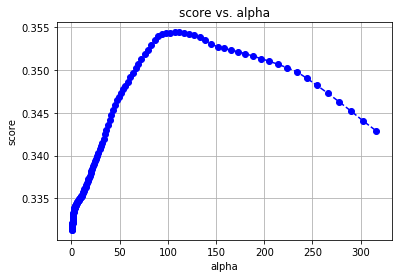

The optimaized alpha and score of Lasso linear is: 


(None, 107.20161850474553, 0.35440554960326276)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

lr_train, lr_validate = train_test_split(model_train, test_size=0.15, random_state = 0)

lr_train_x = lr_train.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_validate_x = lr_validate.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_train_y = lr_train['cvt_per_day']
lr_validate_y = lr_validate['cvt_per_day']

alphas = np.logspace (-0.3, 2.5, num=150)
# alphas= [0.000000001]
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(lr_train_x, lr_train_y)
    scores[i] = lasso.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print ('The optimaized alpha and score of Lasso linear is: '), opt_a, max_score


In [0]:
# combine the validate data and training data, use the optimal alpha, re-train the model
lasso_f = Lasso()
lasso_f.set_params(alpha = opt_a)
lasso_f.fit(model_train_x, model_train_y)


Lasso(alpha=107.20161850474553, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

### 3.2 Lasso linear regression Polynomial-2

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33511299074.619617, tolerance: 48022560.445868425
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33519660034.652542, tolerance: 48022560.445868425
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33529311849.39215, tolerance: 48022560.445868425
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3354044

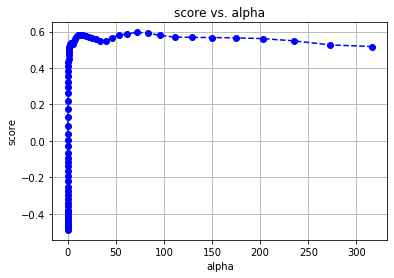

The optimaized alpha and score of Lasso polynomial is: 


(None, 71.52047328767571, 0.5960567939749867)

In [0]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

lr_train, lr_validate = train_test_split(model_train, test_size=0.15, random_state = 0)

lr_train_x = lr_train.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_validate_x = lr_validate.drop(['video_id', 'cvt_per_day'], axis = 1)

lr_train_xp = poly.fit_transform(lr_train_x)
lr_validate_xp = poly.fit_transform(lr_validate_x)
lr_train_y = lr_train['cvt_per_day']
lr_validate_y = lr_validate['cvt_per_day']

# lr_train_xp = pd.DataFrame(data=lr_train_xp, index=data[:], columns=data[0,1:]) 

alphas = np.logspace (-2.6, 2.5, num=80)
# alphas= [1]
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(lr_train_xp, lr_train_y)
    scores[i] = lasso.score(lr_validate_xp, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
        
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print ('The optimaized alpha and score of Lasso polynomial is: '), opt_a, max_score



In [0]:
# combine the validate data and training data, use the optimal alpha, re-train the model
lr_train_xp1 = poly.fit_transform(model_train_x)

lasso_fp = Lasso()
lasso_fp.set_params(alpha = opt_a)
lasso_fp.fit(lr_train_xp1, model_train_y)

# lasso_fp is the Lasso model (polynomial feature), to be tested with test data.

Lasso(alpha=71.52047328767571, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

## 3.3 Ridge linear regression

1) All featuers are linear

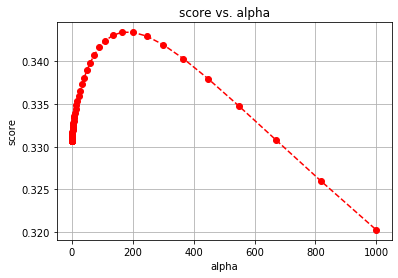

The optimaized alpha and score of Ridge linear is: 


(None, 200.453398090524, 0.3434304876015476)

In [0]:
# Use the same training data set as Lasso (linear features)
lr_train, lr_validate = train_test_split(model_train, test_size=0.15, random_state = 0)

alphas = np.logspace (-10, 3, num=150)
# alphas= [0.000000001]
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    ridge = Ridge()
    ridge.set_params(alpha = a)
    ridge.fit(lr_train_x, lr_train_y)
    scores[i] = ridge.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        ridge_save = ridge
plt.plot(alphas, scores, color='r', linestyle='dashed', marker='o',markerfacecolor='r', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print ('The optimaized alpha and score of Ridge linear is: '), opt_a, max_score

In [0]:
# add the 15% validate data, use the optimal alpha, re-train the model

ridge_f = Ridge()
ridge_f.set_params(alpha = opt_a)
ridge_f.fit(model_train_x, model_train_y)

# ridge_f is the Ridge model (linear feature), to be tested with test data.

Ridge(alpha=200.453398090524, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

## 3.4 Ridge linear regression Polynomial-2

1.   List item
2.   List item



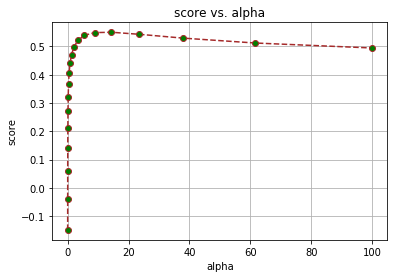

The optimaized alpha and score of Ridge linear is: 


(None, 14.38449888287663, 0.5503906764447627)

In [0]:
# Use the same training data set as Lasso (polynomial features)
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)

lr_train, lr_validate = train_test_split(model_train, test_size=0.15, random_state = 0)

lr_train_x = lr_train.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_validate_x = lr_validate.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_train_y = lr_train['cvt_per_day']
lr_validate_y = lr_validate['cvt_per_day']

lr_train_xp = poly.fit_transform(lr_train_x)
lr_validate_xp = poly.fit_transform(lr_validate_x)

alphas = np.logspace (-2, 2, num=20)
# alphas= [1]
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    ridge = Ridge()
    ridge.set_params(alpha = a)
    ridge.fit(lr_train_xp, lr_train_y)
    scores[i] = ridge.score(lr_validate_xp, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        ridge_save = ridge
        
plt.plot(alphas, scores, color='brown', linestyle='dashed', marker='o',markerfacecolor='g', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print ('The optimaized alpha and score of Ridge linear is: '), opt_a, max_score


##3.5 Random Forest

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rf=RandomForestRegressor(random_state=2,max_features='sqrt',n_jobs=-1)
param_grid={'n_estimators':[55,56,57,58,59,60,61,62,63,64,65],'max_depth':[15,16,17,18,19,20,21]}
clf=GridSearchCV(estimator=rf,param_grid=param_grid,cv=5,refit=True,n_jobs=-1,pre_dispatch='2*n_jobs')
clf.fit(train_x,train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=2,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1

{'mean_fit_time': array([0.42133403, 0.44800544, 0.42832508, 0.43195114, 0.42746067,
       0.45399394, 0.44919252, 0.43540907, 0.44622083, 0.4491643 ,
       0.46188264, 0.40752339, 0.42752995, 0.43539348, 0.41539583,
       0.43252892, 0.44477983, 0.41700974, 0.44479299, 0.45923905,
       0.4606163 , 0.52045488, 0.44231114, 0.4323164 , 0.44378915,
       0.42671409, 0.44425926, 0.42730341, 0.52903748, 0.5296783 ,
       0.54834061, 0.54246402, 0.55006475, 0.48857503, 0.44784484,
       0.4393177 , 0.45201564, 0.4583406 , 0.49427538, 0.53396597,
       0.5307601 , 0.55452876, 0.50407391, 0.52090335, 0.44395061,
       0.43364787, 0.44359727, 0.47742786, 0.46871667, 0.46708155,
       0.50035014, 0.50920038, 0.53781772, 0.52468944, 0.5428472 ,
       0.48298883, 0.52895432, 0.5243803 , 0.55011358, 0.56598916,
       0.54085026, 0.63489575, 0.61165872, 0.62354984, 0.61309161,
       0.65323176, 0.51954222, 0.54845138, 0.54573932, 0.61105313,
       0.56341896, 0.54537053, 0.52257929, 0

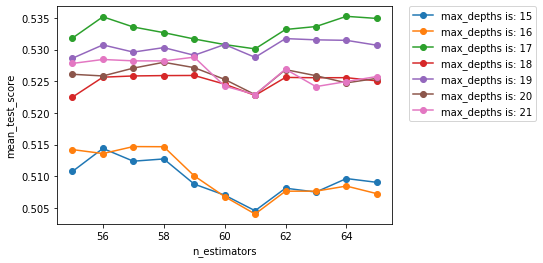

the best parameter for max_depth is: 17
the best parameter for n_estimators is: 64


In [0]:
result=clf.cv_results_
print(result)
max_depth=[15,16,17,18,19,20,21]
n_estimators=[55,56,57,58,59,60,61,62,63,64,65]
scores=clf.cv_results_['mean_test_score'].reshape(len(max_depth),len(n_estimators))
plt.figure(1)
plt.subplot(1,1,1)
for i,j in enumerate(max_depth):
  plt.plot(n_estimators,scores[i],'-o',label='max_depths is: '+str(j))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('mean_test_score')
plt.ylabel('n_estimators')
plt.show()
print('the best parameter for max_depth is: '+str(clf.best_params_['max_depth']))
print('the best parameter for n_estimators is: '+str(clf.best_params_['n_estimators']))



# Part 4: Model Evaluation

## 4.1: Evaluate all models

In [0]:
#For lasso, the optimal alpha is 107.20161850474553
from sklearn.linear_model import Lasso
from sklearn.metrics import  mean_squared_error
lasso=Lasso(alpha=107.20161850474553)
lasso.fit(train_x,train_y)
pred_y=lasso.predict(test_x)
lasso_score=lasso.score(test_x,test_y)
MSE_lasso=mean_squared_error(test_y,pred_y)
RMSE_lasso=np.sqrt(MSE_lasso)
print ('lasso score: ', lasso_score)
print ('Mean square error of lasso: ', MSE_lasso)
print ('Root mean squared error of lasso:', RMSE_lasso)

lasso score:  0.2491275911379487
Mean square error of lasso:  156220566.67335564
Root mean squared error of lasso: 12498.822611484477


In [0]:
#for lasso with polynomial feature alpha is 71.52047328767571
from sklearn.preprocessing import PolynomialFeatures
poly=PolynomialFeatures(2)
train_x_p=poly.fit_transform(train_x)
test_x_p=poly.fit_transform(test_x)
lasso_p=Lasso(alpha=71.52047328767571)
lasso_p.fit(train_x_p,train_y)
pred_y=lasso_p.predict(test_x_p)
lasso_p_score=lasso.score(test_x,test_y)
MSE_lasso_p=mean_squared_error(test_y,pred_y)
RMSE_lasso_p=np.sqrt(MSE_lasso_p)
print ('lasso_p score: ', lasso_p_score)
print ('Mean square error of lasso_p: ', MSE_lasso_p)
print ('Root mean squared error of lasso_p:', RMSE_lasso_p)


lasso_p score:  0.2491275911379487
Mean square error of lasso_p:  151116998.73637503
Root mean squared error of lasso_p: 12292.965416707842


In [0]:
#for ridge,the optimal alpha is 200.453398090524
from sklearn.linear_model import Ridge
from sklearn.metrics import  mean_squared_error
ridge=Ridge(alpha=200.453398090524)
ridge.fit(train_x,train_y)
pred_y=ridge.predict(test_x)
ridge_score=ridge.score(test_x,test_y)
MSE_ridge=mean_squared_error(test_y,pred_y)
RMSE_ridge=np.sqrt(MSE_ridge)
print ('ridge score: ', ridge_score)
print ('Mean square error of ridge: ', MSE_ridge)
print ('Root mean squared error of ridge:', RMSE_ridge)

ridge score:  0.25319910482985264
Mean square error of ridge:  155373479.7799492
Root mean squared error of ridge: 12464.889882383606


In [0]:
#for lasso with polynomial feature alpha is 14.38449888287663
from sklearn.preprocessing import PolynomialFeatures
poly=PolynomialFeatures(2)
train_x_p=poly.fit_transform(train_x)
test_x_p=poly.fit_transform(test_x)
ridge_p=Ridge(alpha=14.38449888287663)
ridge_p.fit(train_x_p,train_y)
pred_y=ridge_p.predict(test_x_p)
ridge_p_score=ridge.score(test_x,test_y)
MSE_ridge_p=mean_squared_error(test_y,pred_y)
RMSE_ridge_p=np.sqrt(MSE_ridge_p)
print ('ridge_p score: ', ridge_p_score)
print ('Mean square error of ridge_p: ', MSE_ridge_p)
print ('Root mean squared error of ridge_p:', RMSE_ridge_p)

ridge_p score:  0.25319910482985264
Mean square error of ridge_p:  161094739.66072002
Root mean squared error of ridge_p: 12692.310257030436


In [0]:
#For randomforest regression, the optimal n_estimators is 64 , the optimal max_depth is 17
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=64,max_depth=17,max_features='sqrt',random_state=2,n_jobs=-1)
rf.fit(train_x,train_y)
pred_y=rf.predict(test_x)
rf_score=rf.score(test_x,test_y)
MSE_rf=mean_squared_error(test_y,pred_y)
RMSE_rf=np.sqrt(MSE_rf)
print ('rf score: ', rf_score)
print ('Mean square error of rf: ', MSE_rf)
print ('Root mean squared error of rf:', RMSE_rf)


rf score:  0.5941448620059838
Mean square error of rf:  84439005.74373932
Root mean squared error of rf: 9189.069906347395


## 4.2 Model comparison 

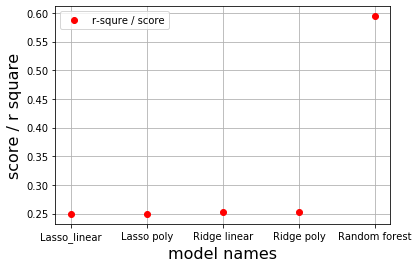

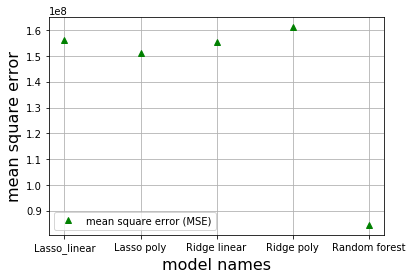

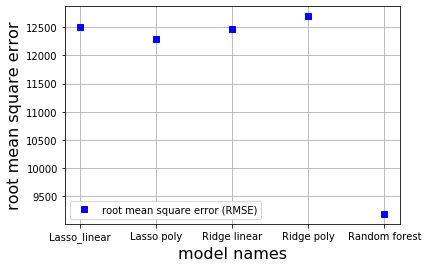

In [0]:
lst_score = [lasso_score, lasso_p_score, ridge_score, ridge_p_score, rf_score]
MSE_lst =  [MSE_lasso, MSE_lasso_p, MSE_ridge, MSE_ridge_p, MSE_rf]
RMSE_lst =  [RMSE_lasso, RMSE_lasso_p, RMSE_ridge, RMSE_ridge_p, RMSE_rf]
model_lst = ['Lasso_linear','Lasso poly', 'Ridge linear', 'Ridge poly', 'Random forest']

plt.figure(1)
plt.plot(model_lst, lst_score, 'ro')
plt.legend(['r-squre / score'])
plt.xlabel('model names',fontsize =16)
plt.ylabel('score / r square', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(2)
plt.plot(model_lst, MSE_lst, 'g^')
plt.legend(['mean square error (MSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('mean square error', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(3)
plt.plot(model_lst, RMSE_lst, 'bs')
plt.legend(['root mean square error (RMSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('root mean square error', fontsize =16)
plt.grid(True)
plt.show()

## 4.3 Feature importance

According to MSE,RMSE and R square, the Random Forest Regression has the best performance

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  


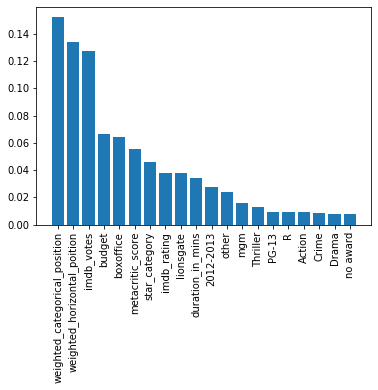

In [0]:
importances = rf.feature_importances_
feature_name = train_x.columns.get_values()
indices = np.argsort(importances)[::-1]
plt.figure(1)
plt.bar(feature_name[indices[:20]], importances[indices[:20]])
plt.xticks(rotation=90)
plt.show()